In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
df = pd.read_csv('covid.csv')
df

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.000000,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.000000,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.000000,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.000000,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.000000,0.038426,0.003435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,United States,United States,0,2022-05-09,2022-05-15,7,2022,19,336997624,57864.0,1868,55510.914407,2353.085593,55996.0,0.554307,0.698250,0.042390
5766,United States,United States,0,2022-05-16,2022-05-22,7,2022,20,336997624,57523.0,2461,54958.314407,2564.685593,55062.0,0.730272,0.761040,0.046666
5767,United States,United States,0,2022-05-23,2022-05-29,7,2022,21,336997624,56959.0,2607,54850.514407,2108.485593,54352.0,0.773596,0.625668,0.038441
5768,United States,United States,0,2022-05-30,2022-06-05,7,2022,22,336997624,57545.0,1956,54459.714407,3085.285593,55589.0,0.580420,0.915521,0.056653


In [6]:
df = df.dropna()
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

# Проверка данных после преобразования дат
print(df[['start_date', 'end_date']].head())
print(df['region'].unique())

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region]

  start_date   end_date
0 2019-12-30 2020-01-05
1 2020-01-06 2020-01-12
2 2020-01-13 2020-01-19
3 2020-01-20 2020-01-26
4 2020-01-27 2020-02-02
['Australia' 'Austria' 'Belgium' 'Britain' 'Bulgaria' 'Canada' 'Chile'
 'Colombia' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Ecuador'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Guatemala' 'Hungary'
 'Iceland' 'Iran' 'Israel' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg'
 'Malta' 'Mexico' 'Montenegro' 'Netherlands' 'New Zealand' 'Norway' 'Peru'
 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'South Africa'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Tunisia' 'United States']


D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_8600\2048757257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['days_since_start'] = (region_df['start_date'] - region_df['start_date'].min()).dt.days


Cross-Validation R² Scores for Gradient Boosting: [-0.17478097  0.83293139  0.74704815  0.65457893  0.68160349]
Mean Cross-Validation R² Score for Gradient Boosting: 0.5482761989022451
R² Score for Gradient Boosting on Test Data: 0.9261894744050245


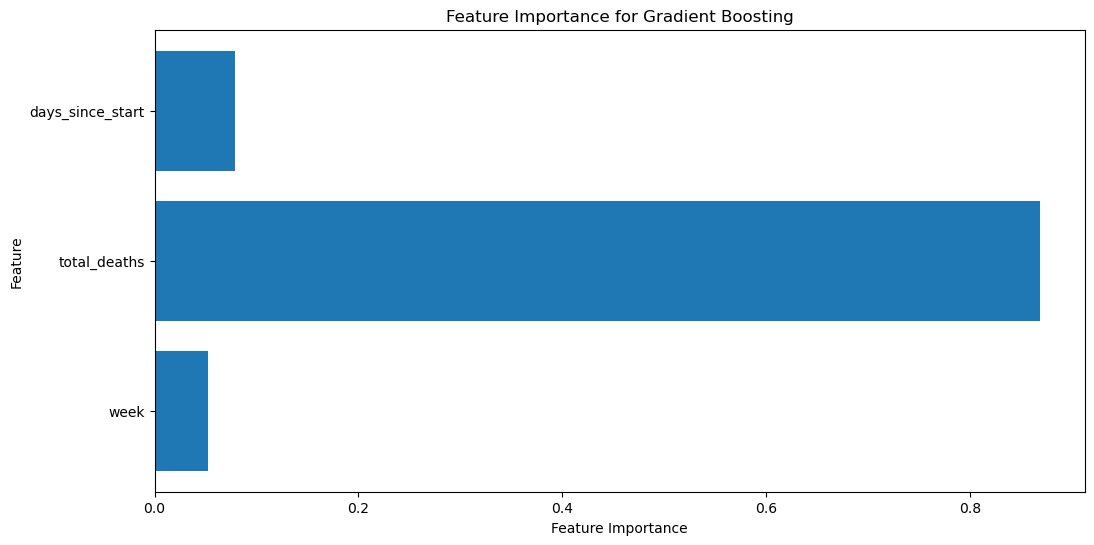

In [7]:
# Градиентный бустинг
region_df['days_since_start'] = (region_df['start_date'] - region_df['start_date'].min()).dt.days
X = region_df[['week', 'total_deaths', 'days_since_start']]
y = region_df['covid_deaths_per_100k']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

# Кросс-валидация
cv_scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring='r2')
print(f'Cross-Validation R² Scores for Gradient Boosting: {cv_scores_gb}')
print(f'Mean Cross-Validation R² Score for Gradient Boosting: {cv_scores_gb.mean()}')

# Прогнозирование на тестовой выборке
y_pred_gb = model_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'R² Score for Gradient Boosting on Test Data: {r2_gb}')

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
plt.barh(X.columns, model_gb.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting')
plt.show()

Модель градиентного бустинга показывает лучшие результаты на тестовой выборке по сравнению с моделью Arima.
ARIMA модель показывает низкое качество предсказаний, с отрицательными значениями как на кросс-валидации, так и на тестовой выборке, в то время как модель градиентного бустинга справляется хорошо